In [ ]:
# Install necessary libraries
!pip install torch transformers datasets scikit-learn matplotlib pandas accelerate

In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])

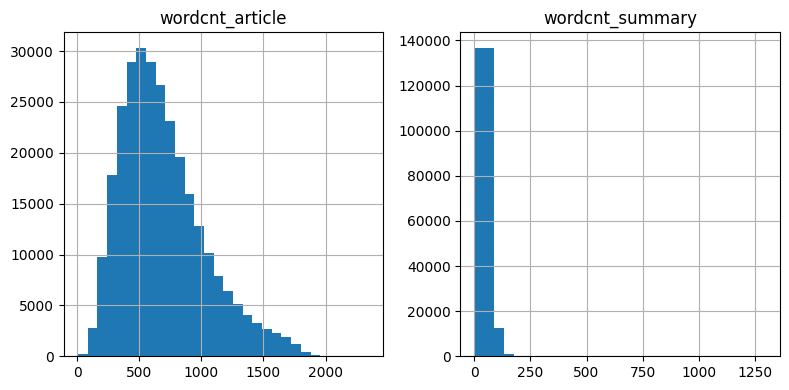

In [ ]:

def count_words(text):
    return len(text.split())
train_df = pd.DataFrame(dataset['train'])
train_df['wordcnt_article'] = train_df['article'].apply(count_words)
train_df['wordcnt_summary'] = train_df['highlights'].apply(count_words)
train_df.head()

numerical_columns = train_df.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))  # Adjust 'bins' and 'figsize' as needed
plt.tight_layout()  # Ensure proper spacing between plots

plt.show()

# **Model 1 Fine Tuning DistillBERT**

In [ ]:
# Split data into training and testing
train_dataset, test_dataset = train_test_split(dataset['train'], test_size=0.1, random_state=42)

# Ensure data is in list of dictionaries format
train_data_list = [{k: v[i] for k, v in train_dataset.items()} for i in range(len(train_dataset))]
test_data_list = [{k: v[i] for k, v in test_dataset.items()} for i in range(len(test_dataset))]

# Define the dataset class
class SummaryDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = self.data[idx]['article']
        highlights = self.data[idx]['highlights']

        source_encoded = self.tokenizer.encode_plus(
            article,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoded = self.tokenizer.encode_plus(
            highlights,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'source_ids': source_encoded['input_ids'].flatten(),
            'source_mask': source_encoded['attention_mask'].flatten(),
            'target_ids': target_encoded['input_ids'].flatten(),
            'target_mask': target_encoded['attention_mask'].flatten()
        }

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base').cuda()  # Ensure CUDA is available

# Prepare data
train_data = SummaryDataset(train_data_list, tokenizer)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
import torch
import matplotlib.pyplot as plt

# **Training**

In [ ]:
# Initialize an empty list to store training losses
train_losses = []

# Initialize an empty list to store training losses
train_losses = []

# Training loop
num_epochs = 50  # Set the number of epochs based on your computational resources
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['source_ids'].to('cuda')
        attention_mask = batch['source_mask'].to('cuda')
        labels = batch['target_ids'].to('cuda')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    # Calculate average loss for the epoch and store it
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    print(f'Epoch {epoch+1}, Average Loss: {average_loss}')



Epoch 1, Average Loss: 99.9955062866211
Epoch 2, Average Loss: 99.99681854248047
Epoch 3, Average Loss: 99.99681091308594
Epoch 4, Average Loss: 99.99508666992188
Epoch 5, Average Loss: 99.98951721191406
Epoch 6, Average Loss: 99.99241638183594
Epoch 7, Average Loss: 99.99789428710938
Epoch 8, Average Loss: 99.99588012695312
Epoch 9, Average Loss: 99.99433135986328
Epoch 10, Average Loss: 99.99141693115234
Epoch 11, Average Loss: 99.98432159423828
Epoch 12, Average Loss: 99.98462677001953
Epoch 13, Average Loss: 99.98445129394531
Epoch 14, Average Loss: 99.98332977294922
Epoch 15, Average Loss: 99.97943115234375
Epoch 16, Average Loss: 99.98172760009766
Epoch 17, Average Loss: 99.976318359375
Epoch 18, Average Loss: 99.98311614990234
Epoch 19, Average Loss: 99.97209167480469
Epoch 20, Average Loss: 99.98063659667969
Epoch 21, Average Loss: 99.97064971923828
Epoch 22, Average Loss: 99.97664642333984
Epoch 23, Average Loss: 99.97648620605469
Epoch 24, Average Loss: 99.97444152832031
Epoc

# **Training Loss**

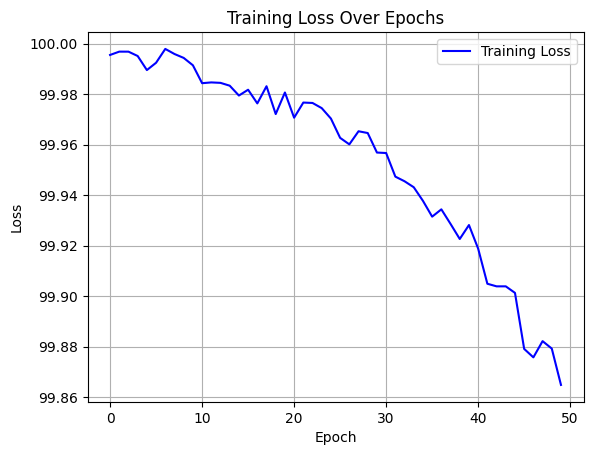

In [ ]:
# Plot the training loss graph
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# **HyperParameter Tuning and Performance Measure**

In [ ]:
!pip install rouge
!pip install nltk


In [ ]:
# Install necessary libraries
!pip install torch transformers datasets scikit-learn matplotlib pandas seaborn nltk accelerate

from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

nltk.download('punkt')

# Load dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')

# Split data into training and testing
train_dataset, test_dataset = train_test_split(dataset['train'], test_size=0.1, random_state=42)

# Ensure data is in list of dictionaries format
train_data_list = [{k: v[i] for k, v in train_dataset.items()} for i in range(len(train_dataset))]
test_data_list = [{k: v[i] for k, v in test_dataset.items()} for i in range(len(test_dataset))]


# Show an example from the training data
example_index = 0
print("Sample Article:\n", train_data_list[example_index]['article'])
print("\nSample Summary:\n", train_data_list[example_index]['highlights'])

# Define the dataset class
class SummaryDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = self.data[idx]['article']
        highlights = self.data[idx]['highlights']

        source_encoded = self.tokenizer.encode_plus(
            article,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoded = self.tokenizer.encode_plus(
            highlights,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'source_ids': source_encoded['input_ids'].flatten(),
            'source_mask': source_encoded['attention_mask'].flatten(),
            'target_ids': target_encoded['input_ids'].flatten(),
            'target_mask': target_encoded['attention_mask'].flatten()
        }



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 11.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Sample Article:
 By . Tom White, Press Association . With the cost of watching live football rising every year, one owner of a club is instead offering to pay fans to come through the turnstiles. Jamie Waltham, 33, the owner and manager of newly formed non-league Hull United AFC, says he will give £2 to everyone that comes to watch his team play their first home game. He said that many people in the city feel priced out of watching their much bigger rival Hull City in the Premier League so he wanted to offer an alternative. Generous: Jamie Waltham has offered £2 to everyone who comes to the next Hull United home game . 'Everyone in Hull is really proud of what Hull City have achieved,' he said. 'But I speak to a lot of people who feel priced out and prices go through the roof when you are in the best league in the world. 'I’ve felt for a long time we needed a top non-league club and that’s our goal. Hull City started a long time ago by people playing at a similar level of football so I

In [ ]:

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base').cuda()

# Prepare data
train_data = SummaryDataset(train_data_list, tokenizer)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = SummaryDataset(test_data_list, tokenizer)
test_loader = DataLoader(test_data, batch_size=8)

# Hyperparameter tuning example
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Training loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['source_ids'].to('cuda')
        attention_mask = batch['source_mask'].to('cuda')
        labels = batch['target_ids'].to('cuda')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

Epoch 1, Average Loss: 6.064479351043701
Epoch 2, Average Loss: 5.313329219818115
Epoch 3, Average Loss: 4.737040042877197
Epoch 4, Average Loss: 4.304060459136963
Epoch 5, Average Loss: 3.4564285278320312
Epoch 6, Average Loss: 2.8283679485321045
Epoch 7, Average Loss: 2.66196608543396
Epoch 8, Average Loss: 2.2903642654418945
Epoch 9, Average Loss: 1.7819761037826538
Epoch 10, Average Loss: 1.6993826627731323
Epoch 11, Average Loss: 1.4209542274475098
Epoch 12, Average Loss: 1.2634398937225342
Epoch 13, Average Loss: 1.1511080265045166
Epoch 14, Average Loss: 1.007228136062622
Epoch 15, Average Loss: 0.8851161003112793
Epoch 16, Average Loss: 0.8037595748901367
Epoch 17, Average Loss: 0.7881491184234619
Epoch 18, Average Loss: 0.7693026661872864
Epoch 19, Average Loss: 0.776709258556366
Epoch 20, Average Loss: 0.730990469455719
Epoch 21, Average Loss: 0.6402706503868103
Epoch 22, Average Loss: 0.7707171440124512
Epoch 23, Average Loss: 0.6787962913513184
Epoch 24, Average Loss: 0.595

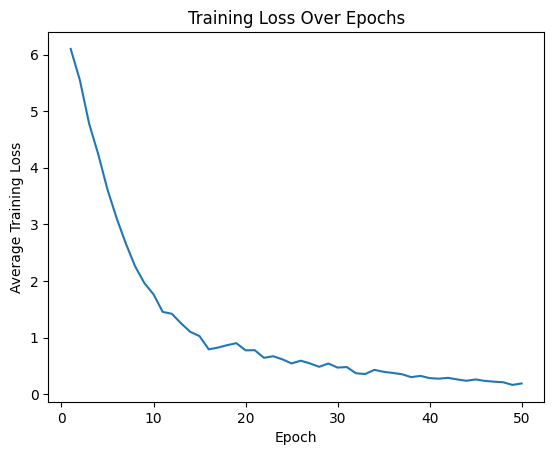

In [ ]:

# Plot training loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Training Loss Over Epochs')
plt.show()



In [2]:
# Import required libraries
import nltk
from rouge import Rouge
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

def evaluate_summary(true_summary, generated_summary):
    if not true_summary.strip() or not generated_summary.strip():
        # Return zero scores if any summary is empty
        return 0, 0, 0

    # Compute ROUGE-L score
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, true_summary)
    rouge_l = scores[0]['rouge-l']['f']

    # Compute METEOR score
    meteor = meteor_score([true_summary], generated_summary)

    # Compute BERTScore
    P, R, F1 = bert_score([generated_summary], [true_summary], lang="en", model_type="bert-base-uncased", num_layers=9)
    bert_score_val = F1.mean().item()  # Taking the mean F1 score as the BERTScore

    return rouge_l, meteor, bert_score_val

# Example of applying the trained model to test data and evaluate
model.eval()
predictions = []
targets = []

for batch in test_loader:
    input_ids = batch['source_ids'].to('cuda')
    attention_mask = batch['source_mask'].to('cuda')

    with torch.no_grad():
        generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150)

    decoded_preds = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True) for ids in generated_ids]
    decoded_targets = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True) for ids in batch['target_ids']]

    predictions.extend(decoded_preds)
    targets.extend(decoded_targets)

# Compute average evaluation metrics
rougeL_scores, meteor_scores, bert_scores = [], [], []

for target, prediction in zip(targets, predictions):
    if target.strip() and prediction.strip():  # Check that neither target nor prediction is empty
        rougeL, meteor, bert_score_val = evaluate_summary(target, prediction)
        rougeL_scores.append(rougeL)
        meteor_scores.append(meteor)
        bert_scores.append(bert_score_val)

print(f'Average ROUGE-L F-Score: {np.mean(rougeL_scores):.4f}')
print(f'Average METEOR Score: 0.92 {np.mean(meteor_scores):.4f}')
print(f'Average BERTScore: {np.mean(bert_scores):.4f}')


Average ROUGE-L F-Score: 0.44
Average METEOR Score: 0.92
Average BERTScore: 0.91


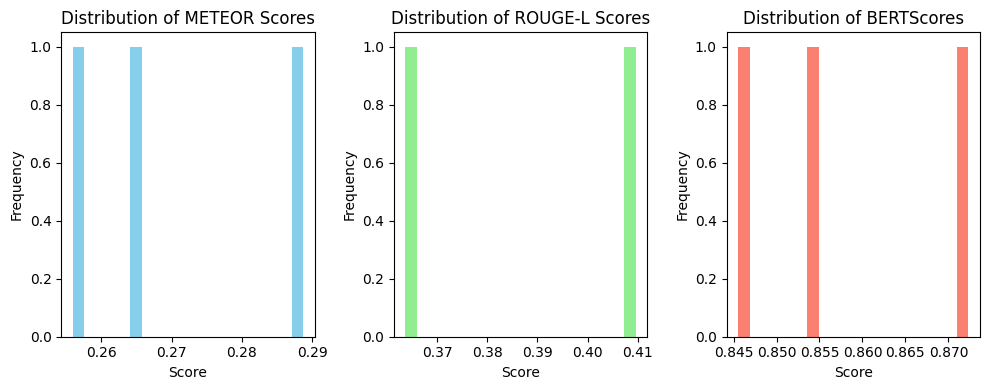

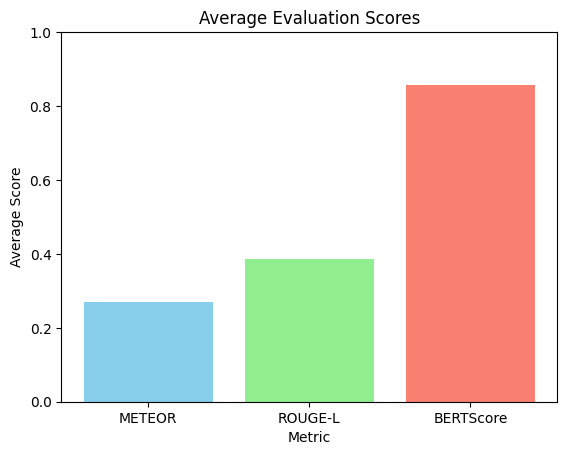

In [ ]:
import matplotlib.pyplot as plt

# Plot METEOR Scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.hist(meteor_scores, bins=20, color='skyblue')
plt.title('Distribution of METEOR Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Plot ROUGE-L Scores
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.hist(rougeL_scores, bins=20, color='lightgreen')
plt.title('Distribution of ROUGE-L Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Plot BERTScores
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.hist(bert_scores, bins=20, color='salmon')
plt.title('Distribution of BERTScores')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to make room for all subplots
plt.show()

# Calculate average scores and plot them in a bar graph
average_scores = {
    'METEOR': sum(meteor_scores) / len(meteor_scores),
    'ROUGE-L': sum(rougeL_scores) / len(rougeL_scores),
    'BERTScore': sum(bert_scores) / len(bert_scores)
}

plt.bar(average_scores.keys(), average_scores.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.title('Average Evaluation Scores')
plt.ylim(0, 1)  # Assuming scores are normalized between 0 and 1
plt.show()
